# IML assignment 2
### Import libraries and data:

In [22]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.covariance import EllipticEnvelope
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

def read_from_file(file):
    df = pd.read_csv(file, header = 0)
    return df._get_numeric_data().values

train_features_file = "train_features.csv"
train_labels_file = "train_labels.csv"
output_file = "submission.txt"

train_features = read_from_file(train_features_file)
labels = read_from_file(train_labels_file)

m = 12  # m = #hours per patient

# Reduce data size for faster testing: (remove this for entire data set)
k = 10000
train_features = train_features[:k*12, :]
labels = labels[:k, :]

n = labels.shape[0] # n = #patients

X_2d = train_features.reshape(n, m, -1)[:, :, 2:]  # features represented as 3D n * m * d_x array
d_x = X_2d.shape[2]  # d_x = #features per patient per hour

X = X_2d[:, :, 1:].reshape(n, m * (d_x - 1))  # features represented as 2D n * m d_x array
X = np.concatenate((X_2d[:, 0, 0].reshape(n, 1), X), axis=1)  # Add age feature seperately so that it is not repated 12 times
Y = labels[:, 1:]
d_y = Y.shape[1]


### Data impution:

In [2]:
# Data impution:
#imputer = KNNImputer(n_neighbors=2, weights="uniform")  # can also do weights="distance"
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # this is a stupid strategy but KNN is too slow?
#imputer = IterativeImputer(max_iter=2, random_state=0)
X_imp = imputer.fit_transform(X)
print(np.shape(X_imp))

(10000, 409)


### Outlier removal:

In [3]:
outliers_fraction = 0.1
clf = EllipticEnvelope(contamination=outliers_fraction, support_fraction=0.7)
clf.fit(X_imp)
print("fit done")
#scores_pred = clf.decision_function(X_imp)
y_pred = clf.predict(X_imp)
print("predict done")
X_inliers = X_imp[y_pred==1]
Y_inliers = Y[y_pred==1]
print(np.shape(X_inliers))

fit done
predict done
(9000, 409)


### Standardization:

In [11]:
scaler = preprocessing.StandardScaler().fit(X_inliers)
#scaler = preprocessing.MinMaxScaler().fit(X_inliers)
X_std = scaler.transform(X_inliers)

In [12]:
# Feature engineering????

### Load test file:

In [13]:
test_features_file = "test_features.csv"
test_features = read_from_file(test_features_file)
n_test = test_features.shape[0] // m
X_2d_test = test_features.reshape(n_test, m, -1)[:, :, 2:]
X_test = X_2d_test[:, :, 1:].reshape(n_test, m * (d_x - 1))
X_test = np.concatenate((X_2d_test[:, 0, 0].reshape(n_test, 1), X_test), axis=1)

In [14]:
#imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_test_imp = imputer.transform(X_test)

X_test_std = scaler.transform(X_test_imp)




### Subtask 1:
Predict whether medical tests are ordered by a clinician in the remainder of the hospital stay: 0 means that there will be no further tests of this kind ordered, 1 means that at least one of a test of that kind will be ordered. In the submission file, you are asked to submit predictions in the interval [0, 1], i.e., the predictions are not restricted to binary. 0.0 indicates you are certain this test will not be ordered, 1.0 indicates you are sure it will be ordered. The corresponding columns containing the binary groundtruth in train_labels.csv are: LABEL_BaseExcess, LABEL_Fibrinogen, LABEL_AST, LABEL_Alkalinephos, LABEL_Bilirubin_total, LABEL_Lactate, LABEL_TroponinI, LABEL_SaO2, LABEL_Bilirubin_direct, LABEL_EtCO2.


In [45]:
# Issue: some patients do not start at hour 1, but 2, 3, 4 etc???

C = 1  # Regularization parameter (inversely proportional, not lambda)
clf = svm.SVC(C=C, kernel='rbf', gamma='scale', probability=False, class_weight='balanced')  # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
#clf = RandomForestClassifier(max_depth=2, random_state=0)

In [51]:
# CV evaluation:
scores = cross_val_score(clf, X_std, Y_inliers[:, 8], cv=5, scoring='f1')
print(scores)

[0.06451613 0.05555556 0.03278689 0.01785714 0.02061856]


In [48]:
# Train, predict, print score:
clf.fit(X_std, Y_inliers[:, 8])
#score = clf.score(X_std, Y_inliers[:, 8])
#print(score)
#solution = clf.decision_function(X_test_std)
#solution = (1 + np.exp(-solution))**-1
#np.savetxt(output_file, solution, fmt='%.10f')

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
# Generate classification metrics:
Y_pred = clf.predict(X_std)
print(metrics.classification_report(Y_inliers[:, 8], Y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      8787
         1.0       0.45      0.99      0.62       213

    accuracy                           0.97      9000
   macro avg       0.72      0.98      0.80      9000
weighted avg       0.99      0.97      0.98      9000



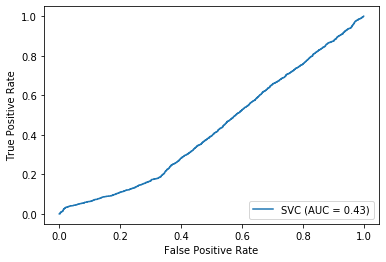

In [50]:
# ROC curve:
metrics.plot_roc_curve(clf, X_std, Y_inliers[:, 7]) 
plt.show()

### Subtask 2:
Predict whether sepsis will occur in the remaining stay: 0 means that no sepsis will occur, 1 otherwise. Similar to Subtask 1, you are asked to produce predictions in the interval [0, 1] for this task. The corresponding column containing the binary groundtruth in train_labels.csv is LABEL_Sepsis.

In [ ]:
# Why is this task different than the one before??

### Subtask 3:
Predict future mean values of key vital signs. The corresponding columns containing the real-valued groundtruth in train_labels.csv are LABEL_RRate, LABEL_ABPm, LABEL_SpO2, LABEL_Heartrate.

In [ ]:
# Do regression instead of classification